In [1]:
import os
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set the data directory (assumes 'combined_dataset' folder is in the current working directory)
data_dir = os.path.join(os.getcwd(), 'combined_dataset')
img_size = (224, 224)
batch_size = 32

# Data augmentation and preprocessing using ResNet50 preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation data generator
val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Load pre-trained ResNet50 model without top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tune: freeze all layers except last 10
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile with low learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Paths to save model and class indices
model_save_path = os.path.join(os.getcwd(), 'best_resnet50_model.keras')
class_indices_path = os.path.join(os.getcwd(), 'class_indices.json')

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(model_save_path, save_best_only=True),
]

# Train the model (Keras handles steps per epoch)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)

# Evaluate the model on validation set
test_loss, test_acc = model.evaluate(val_generator)
print(f'Validation accuracy: {test_acc*100:.2f}%')

# Save class indices for later use
class_indices = train_generator.class_indices
with open(class_indices_path, 'w') as f:
    json.dump(class_indices, f)


Found 20000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


C:\Users\rmish\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7878 - loss: 0.7089

C:\Users\rmish\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 4636s 7s/step - accuracy: 0.7879 - loss: 0.7084 - val_accuracy: 0.9726 - val_loss: 0.0694
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 4582s 7s/step - accuracy: 0.9511 - loss: 0.1459 - val_accuracy: 0.9790 - val_loss: 0.0535
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3927s 6s/step - accuracy: 0.9663 - loss: 0.0935 - val_accuracy: 0.9802 - val_loss: 0.0488
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3284s 5s/step - accuracy: 0.9712 - loss: 0.0778 - val_accuracy: 0.9876 - val_loss: 0.0352
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3035s 5s/step - accuracy: 0.9759 - loss: 0.0659 - val_accuracy: 0.9868 - val_loss: 0.0325
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2981s 5s/step - accuracy: 0.9799 - loss: 0.0570 - val_accuracy: 0.9892 - val_loss: 0.0312
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2950s 5s/step - accuracy: 0.9783 - loss: 0.0581 - val_accuracy: 0.9916 - val_loss: 0.0276
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2893s 5s/step - accuracy: 0.9848 - loss: 0.0443 - val_accurac

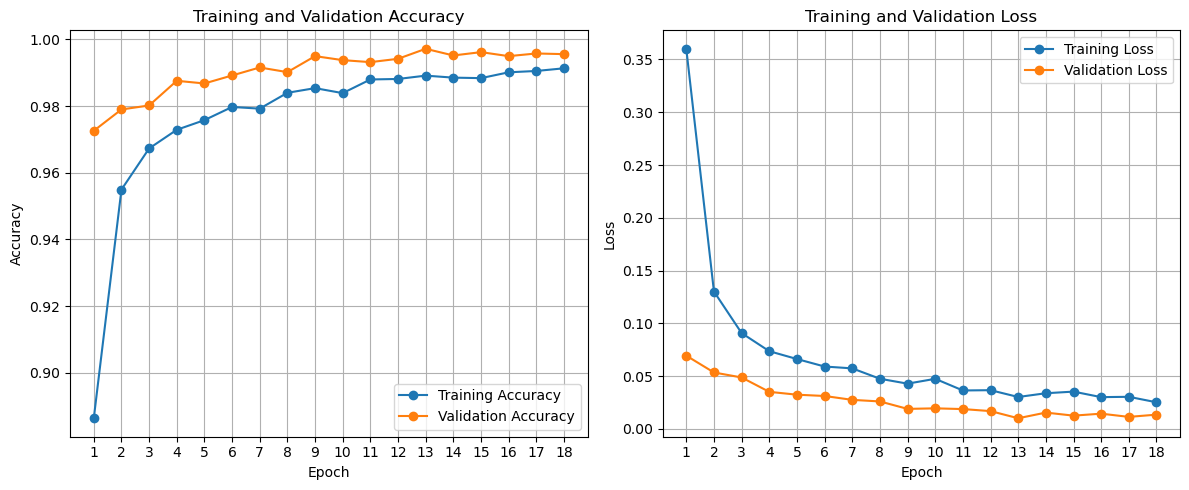

✅ Best validation accuracy at epoch: 13 — 99.72%
157/157 ━━━━━━━━━━━━━━━━━━━━ 654s 4s/step


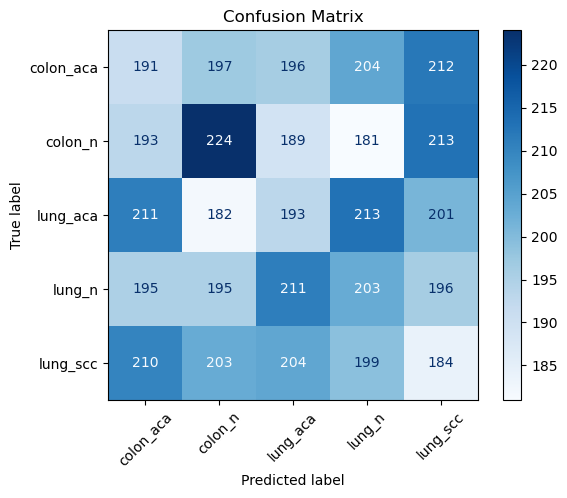

🧾 Classification Report:

              precision    recall  f1-score   support

   colon_aca       0.19      0.19      0.19      1000
     colon_n       0.22      0.22      0.22      1000
    lung_aca       0.19      0.19      0.19      1000
      lung_n       0.20      0.20      0.20      1000
    lung_scc       0.18      0.18      0.18      1000

    accuracy                           0.20      5000
   macro avg       0.20      0.20      0.20      5000
weighted avg       0.20      0.20      0.20      5000



C:\Users\rmish\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


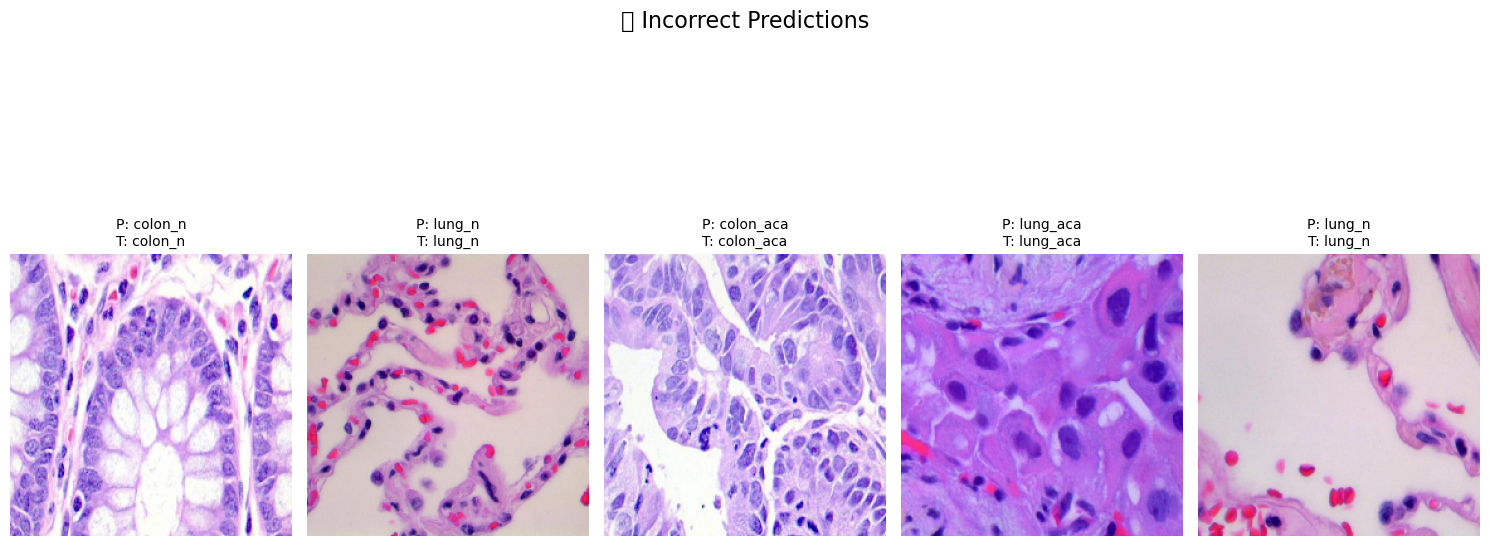

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import random
from tensorflow.keras.preprocessing import image

# === 1. PLOT ACCURACY & LOSS ===
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs_range)
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs_range)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# === 2. BEST EPOCH INFO ===
best_epoch = np.argmax(val_acc) + 1
print(f"✅ Best validation accuracy at epoch: {best_epoch} — {val_acc[best_epoch-1]*100:.2f}%")

# === 3. EVALUATE MODEL PERFORMANCE ===
val_generator.reset()
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get class labels
class_labels = list(val_generator.class_indices.keys())

# === 4. CONFUSION MATRIX ===
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# === 5. CLASSIFICATION REPORT ===
print("🧾 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# === 6. SHOW ONLY INCORRECTLY PREDICTED IMAGES ===
filenames = val_generator.filepaths
incorrect_indices = [i for i, (p, t) in enumerate(zip(y_pred, y_true)) if p != t]

# If there are fewer than 5 incorrect predictions, adjust
sampled_wrong = random.sample(incorrect_indices, min(5, len(incorrect_indices)))

if sampled_wrong:
    plt.figure(figsize=(15, 7))
    for i, idx in enumerate(sampled_wrong):
        img_path = filenames[idx]
        img = image.load_img(img_path, target_size=img_size)
        img_array = image.img_to_array(img)
        img_array_exp = np.expand_dims(img_array, axis=0)
        img_preprocessed = tf.keras.applications.resnet50.preprocess_input(img_array_exp)

        pred = model.predict(img_preprocessed, verbose=0)
        predicted_label = class_labels[np.argmax(pred)]
        true_label = class_labels[y_true[idx]]

        plt.subplot(1, len(sampled_wrong), i + 1)
        plt.imshow(img)
        plt.title(f"P: {predicted_label}\nT: {true_label}", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle("❌ Incorrect Predictions", fontsize=16, y=1.05)
    plt.show()
else:
    print("✅ No incorrect predictions found in the sample!")
